In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
elec_prod = pd.read_csv(r'C:\Users\shikh\Downloads\Electric_Production.csv')

In [3]:
elec_prod.rename(columns={'DATE' : 'Date'},inplace=True)
variable = 'Value'
elec_prod.loc[:,'Date'] = pd.to_datetime(elec_prod['Date'],infer_datetime_format=True)
elec_prod.set_index('Date',inplace=True)

In [4]:
def stationarity_check(timeseries,data_det):
    
    #Rolling Statistics Test
    roll_mean = timeseries.rolling(window=12).mean()
    roll_std = timeseries.rolling(window=12).std()
    plt.plot(timeseries,color='green', label=data_det)
    plt.plot(roll_mean,color='red', label='Rolling mean')
    plt.plot(roll_std,color='yellow', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title(f'Stationarity check of {data_det} using rolling statistics')
    plt.show(block=False)
    
    #ADFuller Test
    print(f'ADFuller Test results on {data_det} :')
    timeseries.dropna(inplace=True)
    adfuller_test = adfuller(timeseries[variable],autolag='AIC')
    print('Test statistics = ', adfuller_test[0])
    print('p value = ', adfuller_test[1])
    print('no. of lags used = ', adfuller_test[2])
    print('no. of observation used = ', adfuller_test[3])
    for key, item in adfuller_test[4].items():
        print(f'critical value {{key}} = {item}')

1. Data - Value

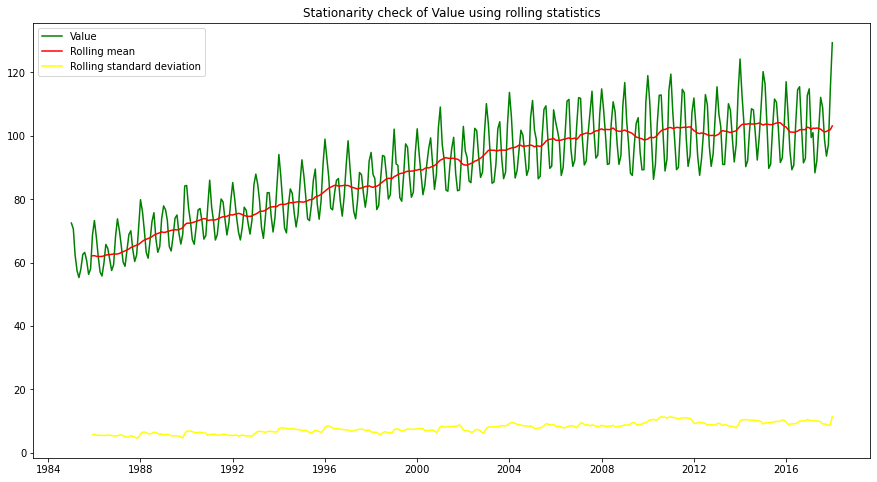

ADFuller Test results on Value :
Test statistics =  -2.2569903500472455
p value =  0.18621469116586759
no. of lags used =  15
no. of observation used =  381
critical value {key} = -3.4476305904172904
critical value {key} = -2.869155980820355
critical value {key} = -2.570827146203181


In [5]:
stationarity_check(elec_prod, 'Value')

2. Data - log(value)

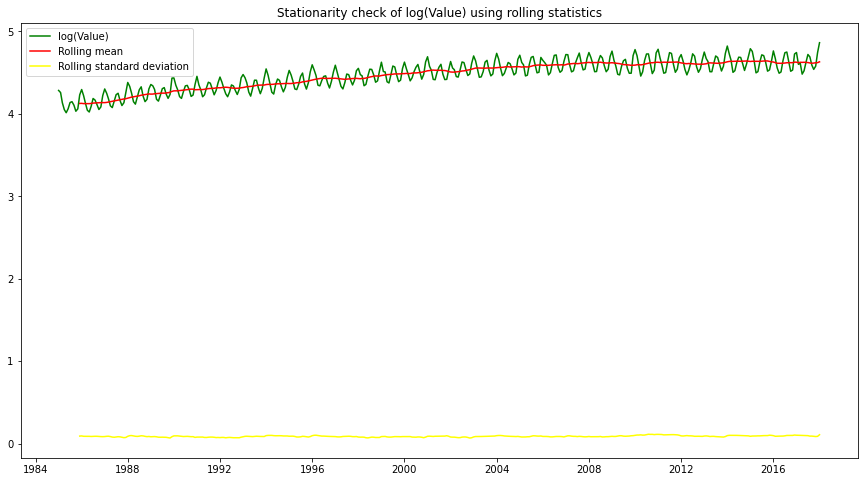

ADFuller Test results on log(Value) :
Test statistics =  -3.1453604281077143
p value =  0.023373401032986168
no. of lags used =  15
no. of observation used =  381
critical value {key} = -3.4476305904172904
critical value {key} = -2.869155980820355
critical value {key} = -2.570827146203181


In [6]:
log_elec_prod = np.log(elec_prod)
stationarity_check(log_elec_prod, 'log(Value)')

3. Data - log(value) - rolling mean

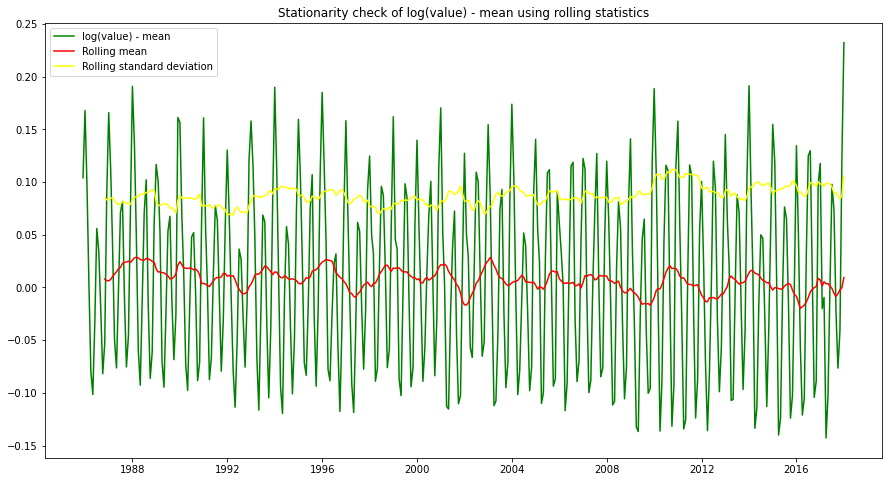

ADFuller Test results on log(value) - mean :
Test statistics =  -5.211586185365455
p value =  8.325639759945464e-06
no. of lags used =  15
no. of observation used =  370
critical value {key} = -3.448147967010838
critical value {key} = -2.8693833397824413
critical value {key} = -2.5709483564645725


In [7]:
roll_mean = log_elec_prod.rolling(window=12).mean()
log_elec_prod_minus_mean = log_elec_prod - roll_mean
log_elec_prod_minus_mean.dropna(inplace=True)
stationarity_check(log_elec_prod_minus_mean, 'log(value) - mean')

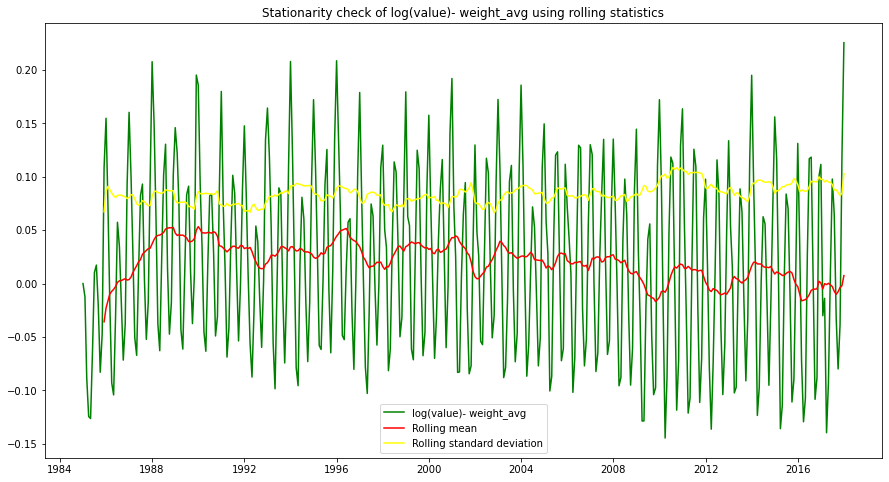

ADFuller Test results on log(value)- weight_avg :
Test statistics =  -3.251531141716208
p value =  0.01718902043373734
no. of lags used =  15
no. of observation used =  381
critical value {key} = -3.4476305904172904
critical value {key} = -2.869155980820355
critical value {key} = -2.570827146203181


In [8]:
expon_decay_weight_avg = log_elec_prod.ewm(halflife=12,min_periods=0,adjust=True).mean()
log_elec_prod_minus_wgt_avg = log_elec_prod - expon_decay_weight_avg
stationarity_check(log_elec_prod_minus_wgt_avg, 'log(value)- weight_avg')

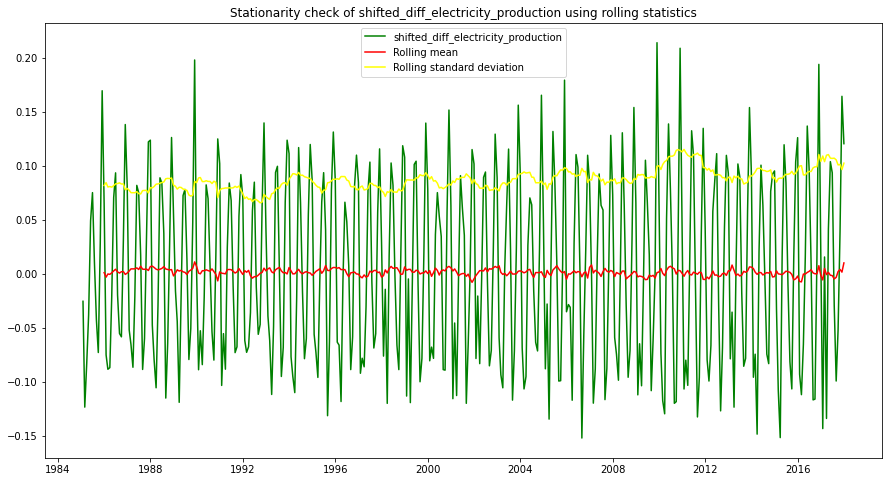

ADFuller Test results on shifted_diff_electricity_production :
Test statistics =  -6.748333370019157
p value =  2.9951614981156204e-09
no. of lags used =  14
no. of observation used =  381
critical value {key} = -3.4476305904172904
critical value {key} = -2.869155980820355
critical value {key} = -2.570827146203181


In [9]:
shifted_log_elec_prod = log_elec_prod.diff()
stationarity_check(shifted_log_elec_prod, 'shifted_diff_electricity_production')

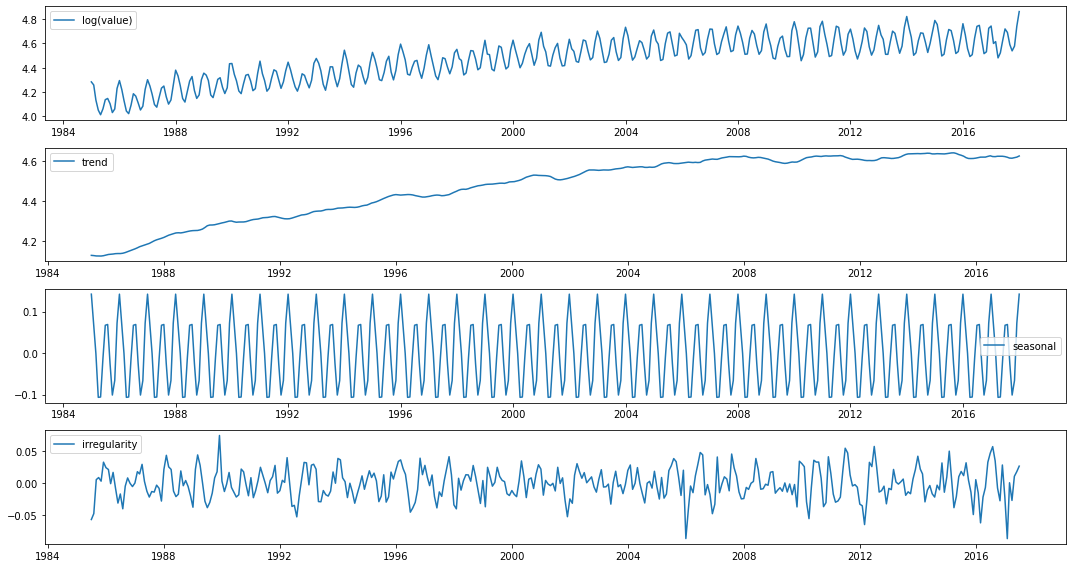

In [10]:
decompose = seasonal_decompose(log_elec_prod)

trend = decompose.trend
seasonal = decompose.seasonal
irregularity = decompose.resid

plt.subplot(411)
plt.plot(log_elec_prod,label='log(value)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label='trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(irregularity,label='irregularity')
plt.legend(loc='best')

plt.tight_layout()

irregularity.dropna(inplace=True)
irregularity = irregularity.to_frame(name='Value')

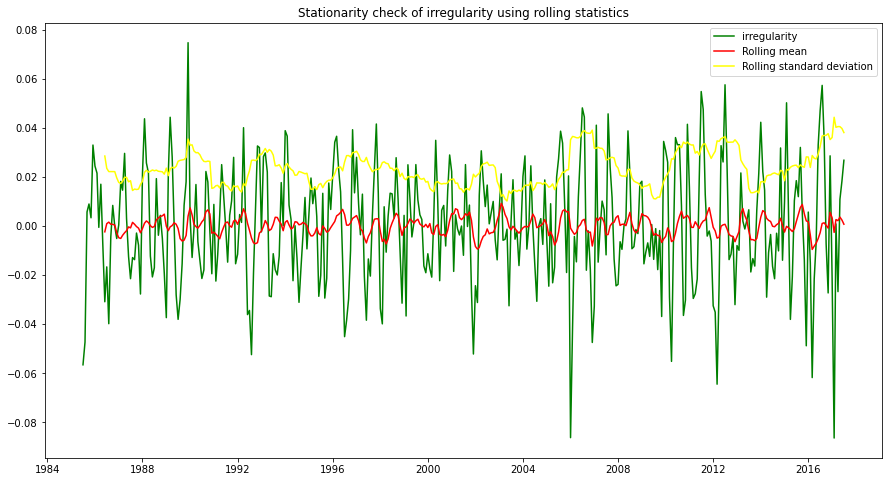

ADFuller Test results on irregularity :
Test statistics =  -10.003109331142385
p value =  1.8616319593842777e-17
no. of lags used =  14
no. of observation used =  370
critical value {key} = -3.448147967010838
critical value {key} = -2.8693833397824413
critical value {key} = -2.5709483564645725


In [11]:
stationarity_check(irregularity, 'irregularity')

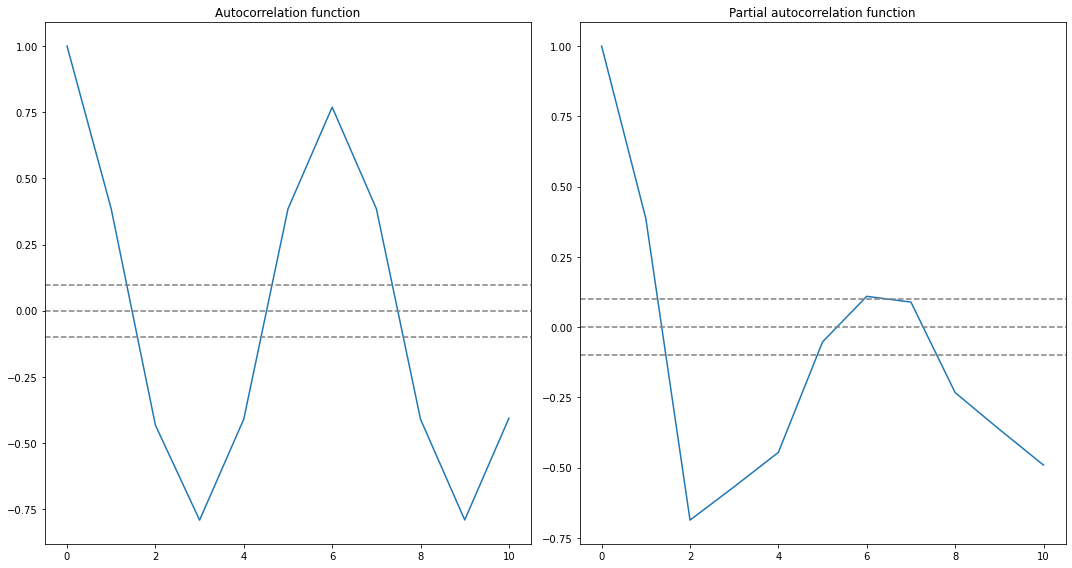

In [12]:
lag_acf = acf(shifted_log_elec_prod,nlags=10)
lag_pacf = pacf(shifted_log_elec_prod,nlags=10,method='ols')
plt.rcParams['figure.figsize'] = [15,8]
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shifted_log_elec_prod)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(shifted_log_elec_prod)),linestyle='--',color='gray')
plt.title('Autocorrelation function')


plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shifted_log_elec_prod)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(shifted_log_elec_prod)),linestyle='--',color='gray')
plt.title('Partial autocorrelation function')
plt.tight_layout()

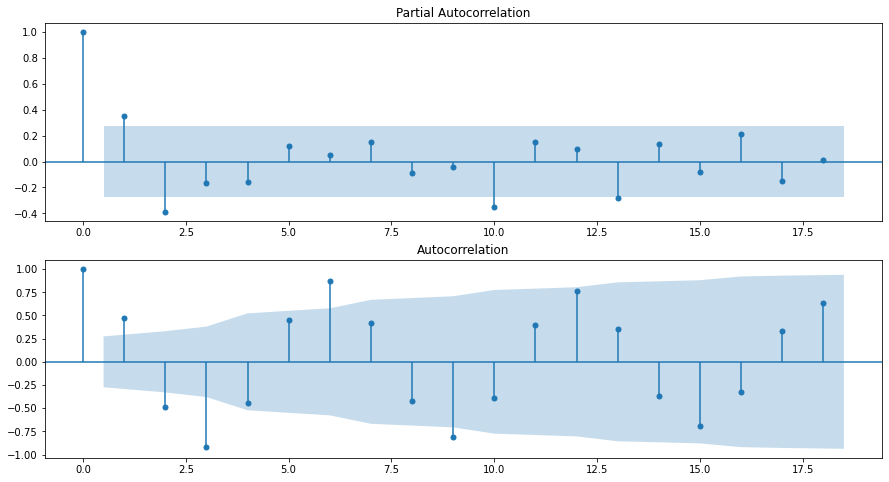

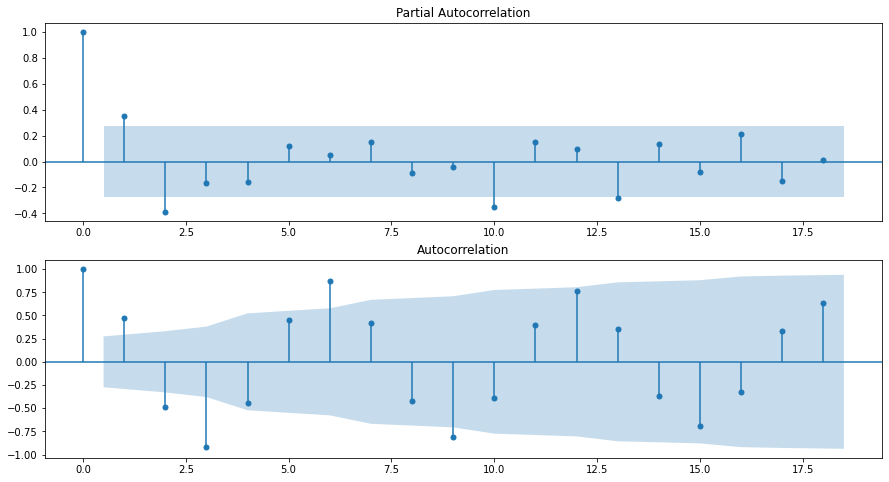

In [14]:
lag_acf1 = acf(shifted_log_elec_prod, nlags=50)
lag_pacf1 = pacf(shifted_log_elec_prod, nlags=50, method='ols')
fig, (ax1, ax2) = plt.subplots(2)
plot_acf(lag_acf1, ax=ax2)
plot_pacf(lag_pacf1,ax=ax1)

Text(0.5, 1.0, 'Residual sum of square = 1.2737842370395185')

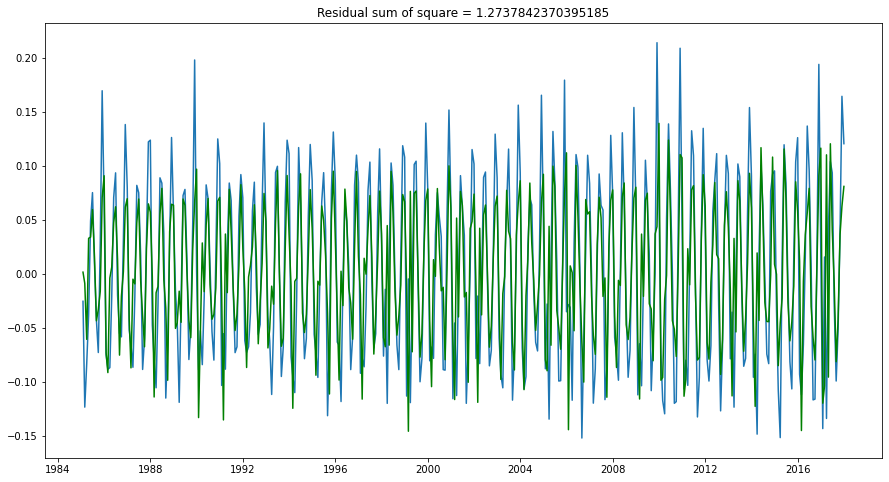

In [15]:
# AR model
model = ARIMA(log_elec_prod, order=(2,1,0))
result_ARIMA = model.fit(disp=False)
plt.plot(shifted_log_elec_prod)
plt.plot(result_ARIMA.fittedvalues,color='green')
plt.title(f'Residual sum of square = {sum((result_ARIMA.fittedvalues - shifted_log_elec_prod[variable])**2)}')

Text(0.5, 1.0, 'Residual sum of square = 1.9318045416852907')

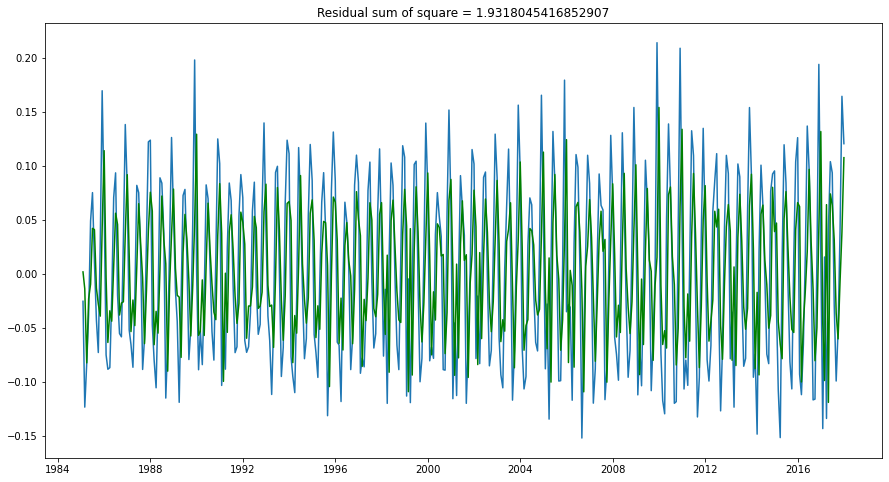

In [16]:
# MA model
model = ARIMA(log_elec_prod, order=(0,1,2))
result_ARIMA = model.fit(disp=False)
plt.plot(shifted_log_elec_prod)
plt.plot(result_ARIMA.fittedvalues,color='green')
plt.title(f'Residual sum of square = {sum((result_ARIMA.fittedvalues - shifted_log_elec_prod[variable])**2)}')

Text(0.5, 1.0, 'Residual sum of square = 0.5177347743912756')

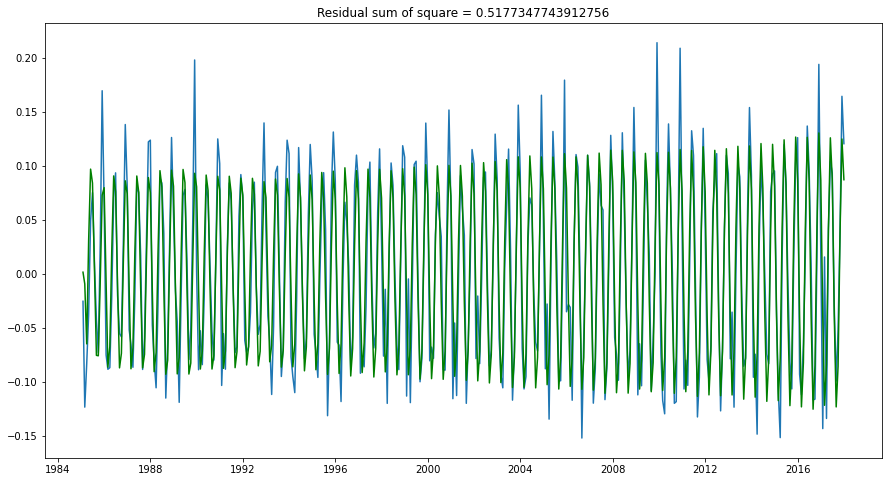

In [17]:
model = ARIMA(log_elec_prod, order=(2,1,2))
result_ARIMA = model.fit(disp=False)
plt.plot(shifted_log_elec_prod)
plt.plot(result_ARIMA.fittedvalues,color='green')
plt.title(f'Residual sum of square = {sum((result_ARIMA.fittedvalues - shifted_log_elec_prod[variable])**2)}')

In [18]:
pred_arima_diff = pd.Series(result_ARIMA.fittedvalues, copy=True)
pred_arima_diff.head()

Date
1985-02-01    0.001365
1985-03-01   -0.009492
1985-04-01   -0.065071
1985-05-01    0.030279
1985-06-01    0.096866
dtype: float64

In [19]:
prediction_arima_diff_cumsum = pred_arima_diff.cumsum()
prediction_arima_diff_cumsum

Date
1985-02-01    0.001365
1985-03-01   -0.008127
1985-04-01   -0.073198
1985-05-01   -0.042918
1985-06-01    0.053947
                ...   
2017-09-01    0.539377
2017-10-01    0.453421
2017-11-01    0.491134
2017-12-01    0.615916
2018-01-01    0.702965
Length: 396, dtype: float64

In [20]:
prediction_arima_log = pd.Series(log_elec_prod[variable].iloc[0],index=log_elec_prod.index)
prediction_arima_log = prediction_arima_log.add(prediction_arima_diff_cumsum,fill_value=0)
prediction_arima_log

Date
1985-01-01    4.283658
1985-02-01    4.285023
1985-03-01    4.275531
1985-04-01    4.210461
1985-05-01    4.240740
                ...   
2017-09-01    4.823035
2017-10-01    4.737080
2017-11-01    4.774792
2017-12-01    4.899575
2018-01-01    4.986624
Length: 397, dtype: float64

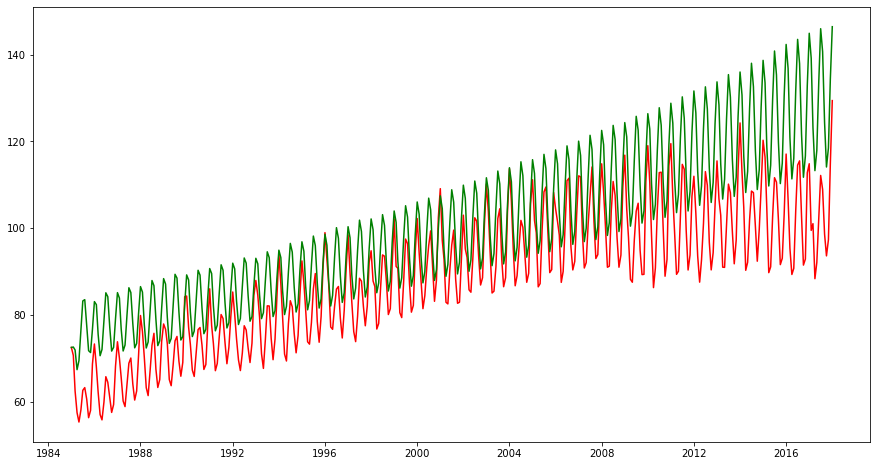

In [21]:
prediction_arima = np.exp(prediction_arima_log)
plt.plot(elec_prod,color='red')
plt.plot(prediction_arima,color='green')

In [22]:
log_elec_prod

,Value
Date,
1985-01-01,4.283658
1985-02-01,4.258049
1985-03-01,4.134369
1985-04-01,4.051287
1985-05-01,4.013046
...,...
2017-09-01,4.591227
2017-10-01,4.539177
2017-11-01,4.578168


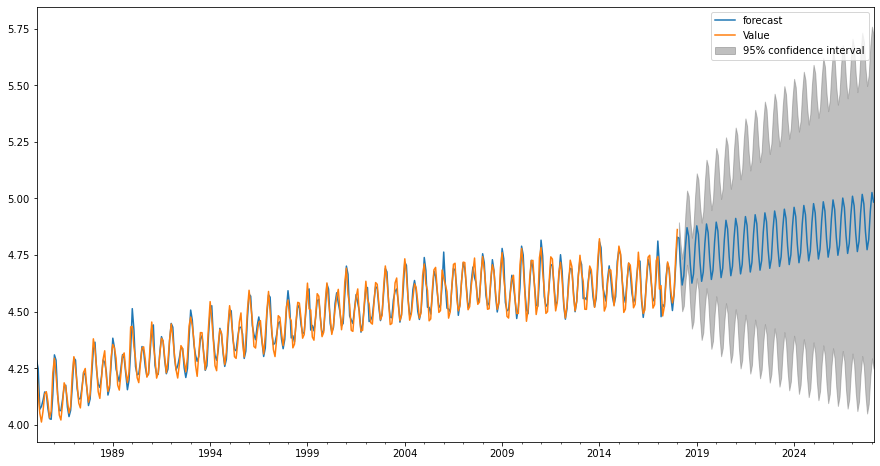

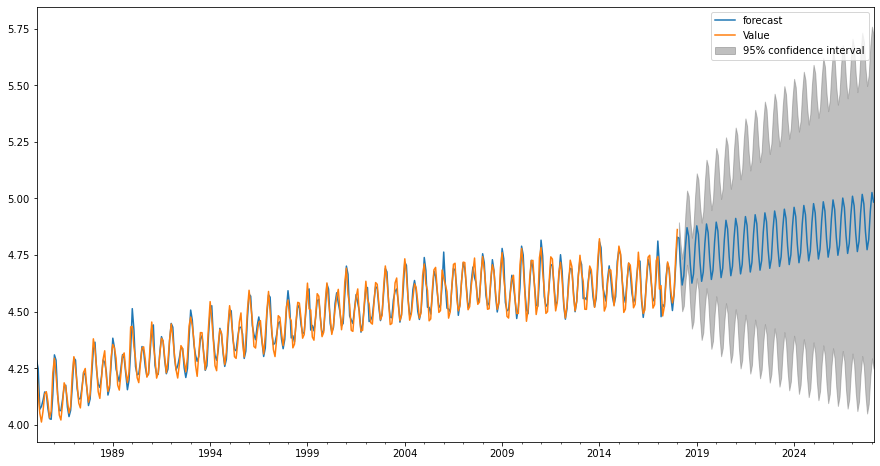

In [23]:
# forcast for 10 years, 10 year = 120 months, 397 + 120 = 517
result_ARIMA.plot_predict(1,517)

In [24]:
result_ARIMA.forecast(steps=120)

(array([4.82536179, 4.70214235, 4.61795193, 4.65838287, 4.78432545,
        4.87112102, 4.83330139, 4.71009426, 4.62615202, 4.66681868,
        4.79274866, 4.87929597, 4.84124086, 4.71804662, 4.6343527 ,
        4.67525462, 4.80117142, 4.88747035, 4.84918019, 4.72599942,
        4.64255397, 4.68369069, 4.80959373, 4.89564413, 4.85711939,
        4.73395268, 4.65075582, 4.6921269 , 4.81801559, 4.90381733,
        4.86505846, 4.74190639, 4.65895825, 4.70056324, 4.82643699,
        4.91198995, 4.8729974 , 4.74986056, 4.66716127, 4.70899971,
        4.83485795, 4.92016199, 4.88093621, 4.75781517, 4.67536486,
        4.71743631, 4.84327845, 4.92833344, 4.88887489, 4.76577025,
        4.68356904, 4.72587304, 4.85169849, 4.93650431, 4.89681344,
        4.77372577, 4.69177381, 4.73430989, 4.86011808, 4.9446746 ,
        4.90475187, 4.78168176, 4.69997915, 4.74274686, 4.86853721,
        4.95284431, 4.91269018, 4.78963819, 4.70818507, 4.75118396,
        4.87695589, 4.96101345, 4.92062836, 4.79